# Sentiment Analysis: Amazon Product Review

## Import Libraries:

In [101]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
!pip install wordcloud


from wordcloud import WordCloud, STOPWORDS
import string
import re

Defaulting to user installation because normal site-packages is not writeable


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

## Load Data:

In [104]:
data = pd.read_csv(r'C:\Users\SANSKAR\Desktop\amazon-review-data.csv.zip')

In [105]:
data.head()

,sr_no,asin,productTitle,productBrand,reviewerName,overall,reviewTime,day_diff,reviewTitle,reviewText,verified_purchase,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,price,producUrl
0,1,B0BHDRW3MK,"JBL Wave Flex, In-Ear Wireless Earphones with ...",JBL,LindsayR,5,04-Jun-24,55,Fantastic and Fast,I previously bought a much more expensive pair...,Verified Purchase,0,0,0,0,0.0,0.000000,42.5,https://www.amazon.co.uk/JBL-Earphones-Waterpr...
1,2,B0BHDRW3MK,"JBL Wave Flex, In-Ear Wireless Earphones with ...",JBL,steven doringf,4,22-Jul-24,7,Vfm,Great sound quality,Verified Purchase,0,0,0,0,0.0,0.000000,42.5,https://www.amazon.co.uk/JBL-Earphones-Waterpr...
2,3,B0BHDRW3MK,"JBL Wave Flex, In-Ear Wireless Earphones with ...",JBL,Victor Perry,5,20-Jul-24,9,Good quality and value for money,Connectivity is superb and of a good quality,Verified Purchase,0,0,0,0,0.0,0.000000,42.5,https://www.amazon.co.uk/JBL-Earphones-Waterpr...
3,4,B0BHDRW3MK,"JBL Wave Flex, In-Ear Wireless Earphones with ...",JBL,VLL,5,18-Nov-23,254,Replacement for Apple Airpods - I'll never go ...,"Bought these to replace Apple Airpods which, a...",Verified Purchase,14,0,14,14,1.0,0.784683,42.5,https://www.amazon.co.uk/JBL-Earphones-Waterpr...
4,5,B0BHDRW3MK,"JBL Wave Flex, In-Ear Wireless Earphones with ...",JBL,Matthew Bontsema,1,04-Jul-24,25,Completely unusable without a serious redesign.,"Nice build quality, decent sound quality, come...",Verified Purchase,0,0,0,0,0.0,0.000000,42.5,https://www.amazon.co.uk/JBL-Earphones-Waterpr...


## Number of Rows and Columns:

In [106]:
data.shape

(14520, 19)

## List of columns:

In [107]:
data.columns

Index(['sr_no', 'asin', 'productTitle', 'productBrand', 'reviewerName',
       'overall', 'reviewTime', 'day_diff', 'reviewTitle', 'reviewText',
       'verified_purchase', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound',
       'price', 'producUrl'],
      dtype='object')

## Select reviewText(feedback) and overall(rating given by customer) Columns:

In [108]:
data1 = data[['reviewText', 'overall']]
data1.head()

,reviewText,overall
0,I previously bought a much more expensive pair...,5
1,Great sound quality,4
2,Connectivity is superb and of a good quality,5
3,"Bought these to replace Apple Airpods which, a...",5
4,"Nice build quality, decent sound quality, come...",1


## Count of each overall(rating) / reviewText(feedback) :

In [109]:
data1.overall.value_counts()

overall
5    9244
4    2654
3    1134
1     880
2     608
Name: count, dtype: int64

<Axes: ylabel='overall'>

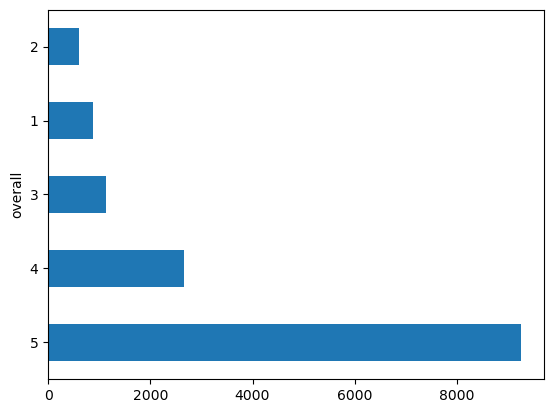

In [110]:
data1.overall.value_counts().plot(kind = 'barh')

#### Check Missing Values:

In [111]:
data1.isnull().sum()

reviewText    2
overall       0
dtype: int64

In [112]:
data1[data1.duplicated()]

,reviewText,overall
528,Good,5
654,Excellent,5
678,Good,5
1121,Good,4
1150,Perfect,5
...,...,...
9604,Very comfortable and really good sound quality.,5
9730,Great,5
12839,good,5
13210,perfect,5


#### Drop duplicates

In [113]:
data2 = data1.drop_duplicates()

In [114]:
data2.shape

(11583, 2)

In [115]:
data2.overall.value_counts()

overall
5    7663
4    1965
3     780
1     739
2     436
Name: count, dtype: int64

#### Positive-Negative-Neutral Reviews:

In [116]:
def map_review(x):
    if x < 3:
        return 'Negative'
    elif x == 3:
        return 'Neutral'
    else:
        return 'Positive'

In [117]:
# data2['Review'] = data2['overall'].apply(lambda x : map_review(x))

data2 = data1[data1['reviewText'].notnull()].copy()
data2.loc[:, 'Review'] = data2['overall'].apply(lambda x: map_review(x))

In [118]:
data2.head()

,reviewText,overall,Review
0,I previously bought a much more expensive pair...,5,Positive
1,Great sound quality,4,Positive
2,Connectivity is superb and of a good quality,5,Positive
3,"Bought these to replace Apple Airpods which, a...",5,Positive
4,"Nice build quality, decent sound quality, come...",1,Negative


In [119]:
data2.Review.value_counts()

Review
Positive    11897
Negative     1487
Neutral      1134
Name: count, dtype: int64

#### Text Cleaning and Preprocessing:

In [120]:
import nltk
!pip install stop-words

from stop_words import get_stop_words
stopwords = get_stop_words('english')

Defaulting to user installation because normal site-packages is not writeable


In [121]:
# stopwords
total_stopwords = set(stopwords)

# subtract negative stopwords like no, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

#
final_stopwords.add("one")
print(final_stopwords)

{'myself', 'as', 'himself', "how's", 'doing', 'her', "she's", 'up', 'very', 'yours', 'yourself', "it's", 'should', "why's", 'their', 'about', 'my', 'or', 'all', 'under', "he'll", "she'd", 'was', 'they', 'having', 'we', 'own', 'those', 'into', 'after', 'has', 'of', 'so', 'you', 'he', "we'll", 'again', "she'll", "i've", 'off', 'which', 'more', 'but', 'few', 'an', 'before', 'am', 'me', 'below', 'same', "i'd", "here's", 'down', 'above', 'here', "you'd", 'such', 'our', 'is', 'during', 'in', 'themselves', 'each', 'i', "we've", 'through', 'by', 'his', 'other', 'out', 'until', 'did', "who's", 'your', 'ourselves', "that's", 'at', 'been', 'do', 'only', "i'll", 'the', "they'd", 'could', 'are', "where's", 'to', 'over', 'ours', 'when', 'while', 'how', 'because', "when's", 'most', 'whom', 'some', 'with', 'on', 'hers', 'a', "we're", 'too', 'herself', 'she', "he'd", "we'd", 'these', 'them', 'between', 'does', 'against', 'where', "he's", 'for', 'its', 'any', 'then', 'who', 'that', 'there', "you're", 'h

In [122]:
#stemming object
stemmer = PorterStemmer()

HTMLTAGS = re.compile('<.*?>')

table = str.maketrans(dict.fromkeys(string.punctuation))

remove_digits = str.maketrans('', '', string.digits)

MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [123]:
def Text_preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove punctuation
    review = review.translate(table)

    # remove digits
    review = review.translate(remove_digits)

    # Lower case all letters
    review = review.lower()
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()

    # remove stop words
    review = [word for word in review.split()
             if word not in final_stopwords]

    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])

    return review

In [124]:
text = 'Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.'

In [125]:
Text_preprocessor(text)

'coffe weaki use pack make cup coffe'

#### WordCloud:

In [126]:
def generate_wcloud(reviewText):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(reviewText)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

#### Postive Review Word Cloud:

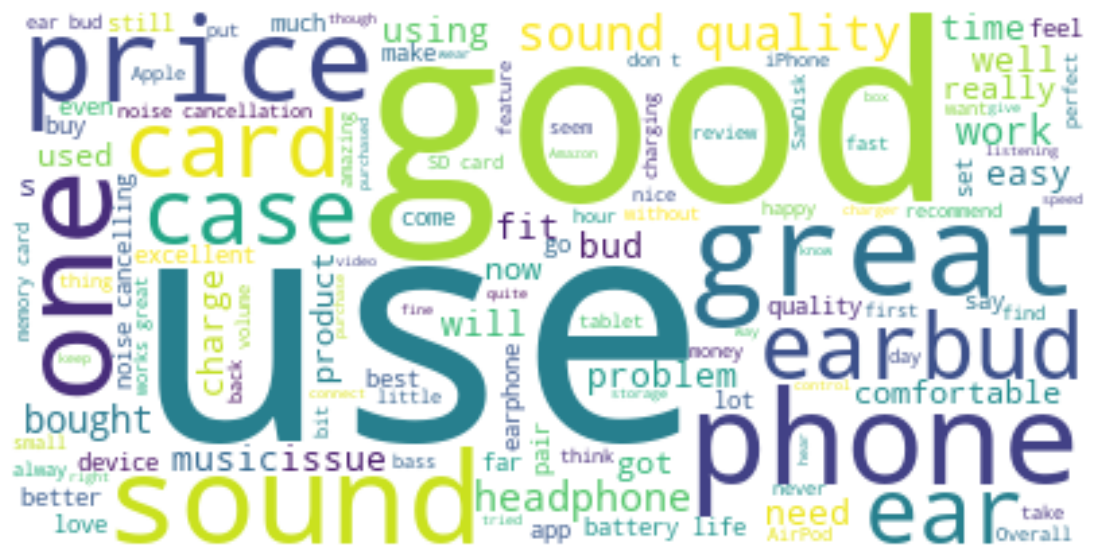

In [127]:
pos = data2.loc[data2.Review == "Positive"].reviewText
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

#### Negative Review Word Cloud:

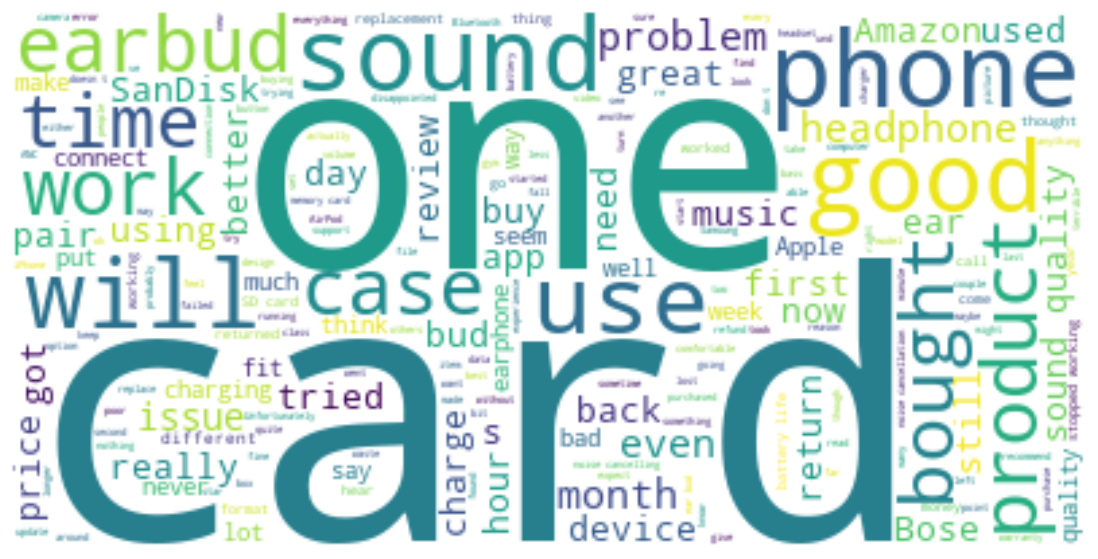

In [128]:
Neg = data2.loc[data2.Review == "Negative"].reviewText
text = " ".join(review for review in Neg.astype(str))

generate_wcloud(text)

#### Neutral Review Word Cloud

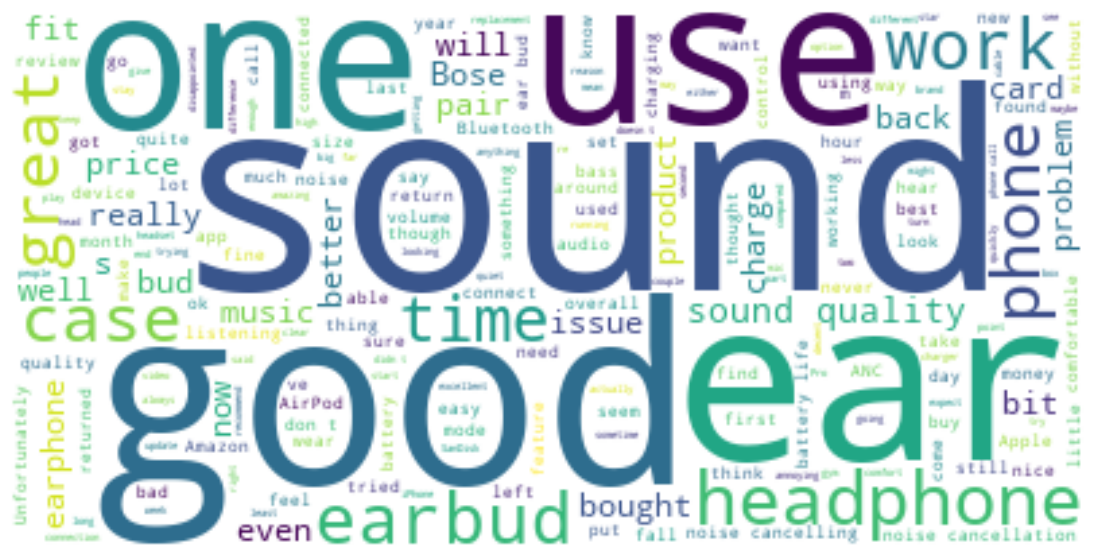

In [129]:
Neut = data2.loc[data2.Review == "Neutral"].reviewText
text = " ".join(review for review in Neut.astype(str))

generate_wcloud(text)

#### Splitting the data into training and testing:

In [130]:
X = data2.reviewText
y = data2.Review

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [131]:
import pandas as pd

X_train = pd.Series(X_train)
X_test = pd.Series(X_test)

print(X_train.shape, X_test.shape)


(11614,) (2904,)


In [132]:
X_train.shape, X_test.shape

((11614,), (2904,))

In [133]:
X_train = X_train.fillna('')  # replace NaNs with empty string
X_test = X_test.fillna('')  # Before fitting the vectorizer, you need to remove or fill NaN values in your text data

#### CountVectorizer:

In [134]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

In [135]:
bow_X_train

<11614x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 552787 stored elements in Compressed Sparse Row format>

#### TfidVectorizer:

In [136]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

#### Label Encoder:

In [137]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
# print(labels) # index -> class

#### Model Training and Evaluation:

In [138]:
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    model.fit(trainX, trainY)
    # Train model with class weight balanced
    # model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=1)
    # model.fit(X_train_tfidf, y_train)

    from sklearn.linear_model import LogisticRegression

    log_model = LogisticRegression(class_weight='balanced', max_iter=1000)



    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n', 40*'-')

#### Logistic Regression : With Hyperparameters & Countvectorizer: 

In [139]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    # log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=1)
    model.fit(X_train_tfidf, y_train)

    # Train and evaluate model
    # train_and_eval(model=log_model,
    #                trainX=bow_X_train,
    #                trainY=y_train,
    #                testX=bow_X_test,
    #                testY=y_test)

    train_and_eval(model=log_model,
               trainX=X_train_tfidf,
               trainY=y_train,
               testX=X_test_tfidf,
               testY=y_test)


NameError: name 'log_model' is not defined

#### Naive-Bayes Model - Hyperparameters & Countvectorizer :

In [ ]:
# alphas = [0, 0.2, 0.6, 0.8, 1]
alphas = [0.2, 0.6, 0.8, 1]


for a in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)
    
    # Train and evaluate model
    # train_and_eval(model=nb_model,
    #                trainX=bow_X_train,
    #                trainY=y_train,
    #                testX=bow_X_test,
    #                testY=y_test)

    train_and_eval(model=log_model,
               trainX=X_train_tfidf,
               trainY=y_train,
               testX=X_test_tfidf,
               testY=y_test)


#### Logistic Regression : With Hyperparameters & tfidf_vectorizer: 

In [ ]:
# Hyperparameters
c = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


#### Naive-Bayes Model - Hyperparameters & tfidf_vectorizer :

In [ ]:
# alphas = [0, 0.2, 0.6, 0.8, 1]
alphas = [0.2, 0.6, 0.8, 1]


for a in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

### Best Model: Logistic Regression(C=1) with Tfidf data

In [ ]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

In [ ]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [ ]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score  : {accuracy_score(y_test, y_preds_test)}")

In [ ]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)

    return plt.show()

plot_cm(y_test, y_preds_test)

### Save model and transformer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Sample setup — adapt it to your data
X = data2['reviewText'].fillna('')
y = data2['Review']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Vectorize
vectorizer = CountVectorizer()
bow_X_train = vectorizer.fit_transform(X_train)
bow_X_test = vectorizer.transform(X_test)

# Fit model
log_model = LogisticRegression(max_iter=500, random_state=1)
log_model.fit(bow_X_train, y_train)


In [ ]:
def get_sentiment(text):
    text_vec = vectorizer.transform([text])
    return log_model.predict(text_vec)[0]

### Prediction on Single review

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Sample label names
labels = ['Negative', 'Neutral', 'Positive']

# Sample text preprocessing function (you can replace with your own)
def Text_preprocessor(text):
    return text.lower().strip()

# Load and prepare data
X = data2['reviewText'].fillna('').apply(Text_preprocessor)
y = data2['Review']  # make sure these are numerical: 0, 1, 2

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train model
model = LogisticRegression(max_iter=500, random_state=1)
model.fit(X_train_tfidf, y_train)

# Prediction function
def get_sentiment(review):
    x = Text_preprocessor(review)
    x_vec = tfidf_vectorizer.transform([x])
    y_pred = model.predict(x_vec)[0]
    return y_pred

In [153]:
# positive review
review = "This product is a worth of money. Buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [154]:
# negative review
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!


In [155]:
review = "Good sound but to big for my ears"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [156]:
# This code is to check neutral reviews
neutral_reviews = data2[data2['Review'] == 'Neutral']